# Modelamiento de Tópicos para reclamos de clientes compañía de telecomunicaciones 

Última modificación: Miercoles 10 de julio 2019

Autor: Francisco Nicolai

# Tabla de contenidos

1. [Introducción](#intro)<br>
    1. [Notas de versión](#version)<br>
    2. [Librerias](#librerias)<br><br>
2. [Bases de datos 2018](#bases)<br>
    1. [Prepago](#prepago)<br>
    2. [Train-Test split y primer guardado](#check1)<br><br>
3. [Procesamiento de texto](#proc1)<br>
    1. [Stemmer, corrector ortográfico y stopwords](#varios)<br>
        1.[Lista blanca](#blanca)<br>
        2.[Lista negra](#negra)<br>
    2. [Función procesamiento](#funcion_maestra)<br>
        1.[Ejemplo de uso](#ejemplo1)<br>
    3. [Aplicación](#aplicación)<br>
        1.[Aplicación preliminar](#preliminar)<br>
        2.[Aplicación completa](#completa)<br>
        3.[Guardado post procesado](#guardado)<br><br>
4. [LDA](#preplda)<br>
    1. [Preparación](#preparacion)<br>
        1.[Creación BoW y preparación corpus](#prep1)<br>
        2.[Creación matriz término documento](#TF)<br>
        3.[Bonus, inspección uso de memoria](#bonus)<br>
        4.[Remoción palabras menos frecuentes corpus](#elim)<br>
    2. [LDA con Gensim](#gensim)<br>
        1.[Librerias Gensim](#libreriasgensim)<br>
        2.[Diccionario y corpus final](#corpusfinal)<br>
        3.[Entrenamiento](#entrenamiento_modelo)<br>
        4.[LDA VIS](#ldavis)<br><br>
5. [Adaptación LDA](#adapt)<br>
    1. [Carga modelos a adaptar](#carga_olda)<br>
    2. [OLDA](#OLDA)<br>
    3. [Desempeño](#desempeño_OLDA)<br>


<a id="intro"></a>
## Introducción

El próposito de este notebook es documentar y dejar en forma clara cada uno de los procesos realizados a lo largo del estudio de requerimientos. Por la naturaleza del trabajo __no se recomienda ejecutar este notebook completamente si no que por partes__.<br>

Para realizar la agrupación de los requerimientos se implementa LDA ([latent dirichlet allocation](https://ai.stanford.edu/~ang/papers/nips01-lda.pdf)) técnica creada por David Blei, Andrew Ng y Michael Jordan.<br>

Esquema de trabajo (figura 1):
<ul>
    <li> Recopilación bases postpago y prepago 2018.</li>
    <li> División de las mismas en conjuntos de entrenamiento y validación (este último etiquetado manualmente)</li>
    <li> <b> Preprocesamiento</b> de las bases (ortografía, bigramas y trigramas, stopwords y stemming. </li>
    <li> <b>Múltiples entrenamientos</b> del modelo LDA buscando mejor desempeño en F-score.</li>
    <li> <b>Implementación del mejor modelo</b> sobre nuevas muestras (mensuales) previamente preprocesadas, la actualización se lleva a cabo en función de muestras clasificadas de forma segura.</li></ul><br>
<img alt="Example of alt text" src="..\img\UntitledDiagram.jpg" title="Diagrama esquema de trabajo del modelo."  width="width" height="height" />
<center>Figura 1: Diagrama esquema de trabajo del modelo.</center>

<a id="version"></a>
---
## Notas versión:

Este código fue __creado para funcionar en linux__, para windows las principales modificaciones son:

```python
        - Agregar if __name__ == "__main__" al inicio celda donde se ejecutará multiprocessing. ```
        
```python
        - Aislar función preprocesamiento (target de multiprocessing) en un archivo .py aislado. ```

Existen __limitantes para a algunas librerias en la nube__, especificamente:
```python
        - nltk.download('stopwords') no funcionará por ende debe cargarse manualmente post descarga.```
```python
        - No se puede instalar la libreria tqdm para visualización progreso en entrenamiento debido a timeout en conexión con pypi.org```       

Dependiendo del equipo que se este utilizando para trabajar los directorios que contienen las bases de datos y funciones de interés serán:


<a id="librerias"></a>
---
## Librerias

Las librerias que deben instalarse para la ejecución  del código son:

In [ ]:
#!pip3 install pyspellchecker    # Corrector ortográfico
#!pip3 install gensim            # Entrenamiento modelo
#!pip3 install pyLDAvis          # Visualización
#!pip3 install wordcloud         # Nubes de palabra
#!pip3 install matplotlib        # Gráficos
#!pip3 install nltk              # Natural Language Tool Kit
#!pip3 install p_tqdm            # Barra de progreso
#!pip3 install pandas

In [ ]:
#Directory
import os
cwd = os.getcwd()
root = os.path.dirname(cwd)
print(root)

import sys
sys.path.append("..")
sys.path.append(os.path.join(root,"src"))

#General
import pandas as pd
import re
import numpy as np
import time
import nltk
import csv
import datetime
import collections
import operator
import unicodedata

#Processing
import multiprocessing
from spellchecker import SpellChecker #https://pypi.org/project/pyspellchecker/
from multiprocessing import Process, current_process, Pool
from IPython.display import display
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SpanishStemmer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from functools import partial
from collections import Counter

import defs
from utils import *

#LDA
import gensim
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from p_tqdm import p_map

#Visualization
import pyLDAvis
import pyLDAvis.gensim

#Performance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

<a id="bases"></a>
---
## [Bases de datos 2018](#intro)

### Toma de muestras y primer preprocesamiento

Teniendose datos de los 12 meses del año para postpago y prepago, se comenzó creando una subselección de los mismos para crear lo que serian el primer conjunto de entrenamiento utilizado (75.000 muestras en postpago) y el conjunto de validación el cual sería etiqutado.<br>

Debido la existencia de múltiples plataformas, existen distintas categorías para las mismas variables de interés, la tabla a continuación muestra las variables de interés respectvias en postpago y prepago.<br>

<table>
  <tr>
    <th>Formato pospago</th>
    <th>Formato prepago</th>
  </tr>
  <tr>
    <td>ID</td>
    <td>ID_Creado</td>
  </tr>
    <tr>
    <td>Fecha_Ingreso</td>
    <td>Mes</td>
  </tr>
    <tr>
    <td>Nombre_Cliente</td>
    <td>Conctacto</td>
  </tr>
    <tr>
    <td>Grupo_cliente</td>
    <td>----------------</td>
  </tr>
    <tr>
    <td>Operacion</td>
    <td>Area</td>
  </tr>
    <tr>
    <td>Suboperacion</td>
    <td>Subárea</td>
  </tr>
    <tr>
    <td>Motivo</td>
    <td>----------------</td>
  </tr>
  <tr>
    <td>Requerimiento_Del_Cliente</td>
    <td>Descripción</td>
  </tr>
</table><br>

<a id="prepago"></a>
---
### Base de datos 2018 prepago
Carga de datos desde archivo plataforma 2 el cual contiene todos los requerimientos del año (ubicado en directorio según indica notas versión).

Para el año 2018 hubo un total de 63.000 requerimientos aprox, para permitir una igual cantidad de requerimientos de cada mes se subseleccionan un total de 5000 requerimientos por mes, para reconstruir los conjuntos que fueron etiquetados y usados como entrenamiento __DEBE mantenerse el random_state=1__.<br>

Debido a que esta base de datos no incluia un Id para cada requerimiento se crea uno manualmente para los mismos antes de subseleccionar.

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#Import dataframe anual
prepago2018 = pd.read_excel(os.path.join(root,"data",'Base Reclamos plataforma 2 2018.xlsx'), delimiter=';') #***
prepago2018 = prepago2018[['ID Creado','Contacto','MES','Grupo cliente','Área','Subárea','Descripción']]
display(prepago2018.head())

# Subelección requerimientos
enero = prepago2018[prepago2018.MES == 1].sample(n = 5000, random_state = 1)
meses = [prepago2018[prepago2018.MES == mes].sample(n = 5000, random_state = 1) for mes in list(range(2,13))]
df_prepago2018 = enero.append(meses, ignore_index=True)
#print(f'Dimensión conjunto de datos TOTAL para prepago: {df_prepago2018.shape}',"\n")

#Extracción requerimientos vacíos
#print(f"Valores nulos base global prepago:\n\n{df_prepago2018.isna().sum()}","\n")
df_prepago2018.dropna(subset=['Descripción'],inplace=True)
df_prepago2018.dropna(subset=['Área'],inplace=True)
#print(f"Valores nulos base global prepago:\n\n{df_prepago2018.isna().sum()}")

<a id="check1"></a>
---
### Creación conjunto de entrenamiento y validación

Originalmente se dividieron los datasets de prepago y postpago en conjuntos de entrenamiento y validación con un 85 y 15% de las muestras respectivamente, generando un conjunto de test de 13500 muestras para postpago y 9000 muestras para prepago. <br>

__Recordar__ que esos conjuntos se mantendrán a través del tiempo como de evaluación mientras que los de entrenamiento variarán.<br>

División en conjuntos de test y validación se generó con __random_state=69__. Para generarlos de nuevo ese es el parámetro de mayor importancia.

In [ ]:
#Creación test y entrenamiento
train_prepago, test_prepago = train_test_split(df_prepago2018, test_size=0.15,random_state=69)

#Guardado en formato Csv (checkpoint_1)
destino = os.path.join(root,"data","checkpoint_prepago_1")
if not os.path.exists(destino):
    os.makedirs(destino)
    
train_prepago.to_csv(os.path.join(destino,"train_prepago2018.csv"), encoding='utf-8', index=False)
test_prepago.to_csv(os.path.join(destino,"test_prepago2018.csv"), encoding='utf-8', index=False)

<a id="proc1"></a>
---
## Procesamiento texto
Para el preprocesamiento del texto se realizan cuatro procesos sobre los requerimientos.
<ul>
    <li> En primer lugar se remueven los caracteres no alfabeticos y se lleva las palabras a minúsculas mediante expresiones regulares.</li>
    <li> Posteriormente se remueven las stopwords referentes a nombres, apellidos y palabras misceláneas que no entragan información (marido, señora, etc).</li>
    <li> Como tercer paso se corrige ortografía mediante el spellcorrector, este paso abarca mayor cantidad de tiempo del preprocesamiento(99%).</li>
    <li> En cuarto lugar se repite el 2do paso.</li>
    <li> Como quinto paso se crean los bigramas y trigramas mediante libreria gensim con algoritmo de Mikolov (1).</li>
    <li> El sexto paso es remover las stopwords referentes a conectores del lenguaje y derivados (con, no, el, la, etc...).</li>
    <li> Finalmente se aplica stemming sobre los requerimientos y se finaliza el preprocesamiento del texto.</li></ul><br>
    
<img alt="Example of alt text" src=..\img\Preprocesado.png title="Diagrama esquema preprocesamiento."  width="width" height="height" />
<center>Figura 1: Diagrama esquema preprocesamiento.</center><br>

Específicamente, el procesamiento detallado anteriormente se ejecuta mediante la función __procesamiento_texto__, esta permite realizar pasos especifícamente definidos del diagrama anterior.

<a id="varios"></a>

### Stemmer y Corrector ortográfico

El stemmer a implementar fue el disponible con el __wrapper SpanishStemmer__ de la libreria "natural language tool kit" (NLTK) el cual fue creado mediante snowball.

La declaración de los métodos de la clase correctora como variables locales se motiva en la reducción de tiempo de localización de los mismos en la memoria por parte del interpretador de python.

In [ ]:
stemmer = SpanishStemmer()

#Creación objeto para corrección ortografía
spell = SpellChecker(language="es")
metodo_desconocidas = spell.unknown
metodo_correccion = spell.correction 

<a id="blanca"></a>
---
#### Lista blanca ortográfica

Se puede modificar la lista blanca de palabras aceptadas por el correcto como se muestra a continuación, el método practicamente hace un append sobre la lista que contiene las palabras válidas.

In [ ]:
lista_blanca_regiones = ["Arica", "Parinacota","Tarapacá","Antofagasta","Atacama","Coquimbo","Valparaíso","Metropolitana", "Santiago","Libertador",
                         "General", "Bernardo","O’Higgins","Maule","Ñuble","Biobío","Araucanía","Ríos","Lagos","Aysén", "General", "Carlos", "Ibáñez",
                         "Campo", "Magallanes", "Antártica"]

lista_blanca_telecom = ['lte','whatsapp','instagram','telegram','youtube','facebook','bafi','resetea','samsung','huawei','iphone',
                                  'kb','mb','pixi','alcatel','movistar','entel','wom','android','tv','rrss']

lista_blanca_telecom.extend(lista_blanca_regiones)
lista_blanca = lista_blanca_telecom

#Se agregan listas a lista de palabras conocidas por corrector
print(spell.known(lista_blanca),"\n")
spell.word_frequency.load_words(lista_blanca)
print(spell.known(lista_blanca))

<a id="negra"></a>
---
### Lista negra (stopwords) desde csv
#### Nombres

Para la exclusión de nombres y apellidos tanto de clientes como del operador/a dentro de los requerimientos se crea un un set de una lista con cada token existente __almenos 2 veces en columna Nombre_Cliente__ dentro de la base de postpago.<br>

La motivación de una cota inferior es el evitar que sustantivos comunes o verbos colados por error en dicha columna formen parte de la lista de stopwords.<br>

En último lugar, debido a la constante aparición de faltas de ortografía en la base se remueven caracteres no alfabéticos dentro de la misma columna.

In [ ]:
stopwords_dir = os.path.join(root,"data","stopwords")
with open(os.path.join(stopwords_dir,"stopwords_1.csv"), 'r', encoding="utf8") as f:
    reader = csv.reader(f)
    stopwords_1 = list(reader)

with open(os.path.join(stopwords_dir,"stopwords_2.csv"), 'r', encoding="utf8") as f:
    reader = csv.reader(f)
    stopwords_2 = list(reader)

stopwords_1 = [item for sublist in stopwords_1 for item in sublist]
stopwords_2 = [item for sublist in stopwords_2 for item in sublist]
print("Cantidad de palabras lista stopwords nombres y técnicas:",len(stopwords_1))
print("Cantidad de palabras lista stopwords lingüistica:",len(stopwords_2))
stopwords_1.extend(stopwords_2)
s_w = stopwords_1.copy()
print("Cantidad de palabras lista stopwords global:",len(s_w))

### Lematizador

Implementación del lematizador consiste en reemplazo según una Look-up-table (LUT) creada por Emilio Torres 2011 (España)

In [ ]:
#Import LUT para lematizador
lematizador_dir = os.path.join(root,"data","lematizador")
with open(os.path.join(lematizador_dir,"lematizador.csv"), 'r', encoding="utf8") as f:
    reader = list(csv.reader(f))
    del reader[0]

#Creación diccionario lematizador, llaves son valores que se desean lematizar, valores serán resultado lematización.
diccionario_lematizador = dict(reader)

def lematizar(palabra, dic=diccionario_lematizador):
    """
    Función lematizar, reemplaza palabra por su forma lematizadas (singular y en infinitivo)
    :param palabra: palabra a lematizar
    :type: str
    :param dic; Diccionario a usar como LUT
    :type: dict
    :return: palabra lematizada
    :type: str
    """
    try:
        palabra = dic[palabra]
    except:
        palabra = palabra
    return palabra

<a id="funcion_maestra"></a>
---
## Función general de procesamiento

Inicialmente se trabaja con expresiones regulares eliminando caracteres no alfanúmericos,mayúsculas y posteriormente se eliminan los números.

In [ ]:
#  Funcion replace_all, reemplaza valores de un string según diccionario cuyas llaves son valores a reemplazar y
# sus valores la nueva asignación.
#  Input: 
#      Text, String entero (no tokenizado).
#      dic, Diccionario, palabras del string no reconocidas por corrector como llaves y respectivas correcciones como valores
#  Output:
#      Text, String entero con reemplazo de palabras diccionario
#  Fuente: #https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
def replace_all(text, dic): 
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

#Función procesamiento_texto, recibe un documento y lo preprocesa con pasos según elección.
# Inputs: 
#     text: DOCUMENTO a preprocesar en FORMATO de STRING, e.g "Cliente Juan reclama por no tener cobertura."
#     stop_list: Lista de stopwords a utilizar.
#     stemming, stopwords, ortografia y tildes, valores lógicos True or False para incluir dicho procesamiento.
# Output: 
#     Documento preprocesado y en formato de tokens
def procesamiento_texto(text, stop_list=s_w, lema=True, stemming=True, stopword=True, ortografia=False, tildes=True):
    text=str(text)
    #Quitar caracteres no alfa numéricos    
    text = re.sub(r'\n', '', text)              #elimina símbolo de salto de línea
    text = text.replace('se?al','señal')        #reemplaza signos de interrogación por símbolo de salto de línea
    text = re.sub(r"\b%s\b" % "liente" , "cliente", text)
    text = re.sub(r"\b%s\b" % "iente" , "cliente", text)
    text = re.sub(r'\.', ' ', text)             #reemplaza puntos por un espacio
    text = re.sub(r'\,', ' ', text)             #reemplaza comas por un espacio
    text = re.sub(r'[^\w\s]','', text)          #elimina los símbolos de puntuación
    text = re.sub(r'[0-9]+', ' ', text)         #elimina los caracteres numéricos
    text = re.sub(r'\b\w{20,}\b', '', text)     #elimina palabras de 20 o mas caracteres

    tokens = text.split()                       #El string es transformado a lista, separador por defecto es un espacio
    tokens = [i.lower() for i in tokens]        #Todo a minúsculas
    tokens = [i for i in tokens if len(i) > 1 and len(i)<15]  #Eliminar tokens con menos de 2 elementos y mas de 14
    
    #Stopwords
    if stopword == True:
        tokens = [i for i in tokens if i not in stop_list]

    #Ortografía
    if ortografia == True:
        espacio = ' '
        text = espacio.join(tokens)
        ##text = untokenize(tokens)
        misspelled = metodo_desconocidas(tokens)# Se identifica aquellas palabras mal escritas
        erradas_lista = list(misspelled)        # Redefine variable en clase de interés (serán llaves)

        correcciones = []
        for word in misspelled:
            correcciones.append(metodo_correccion(word))

        diccionario = dict(zip(erradas_lista, correcciones))
        text = replace_all(text,diccionario)

        tokens = text.split()                          ##El string a lista, separador por defecto es un espacio

        if stopword == True:
            tokens = [i for i in tokens if i not in stop_list]  # Nuevamente se remueven stopwords (caso de que algo se corrigiera a una)

    #Lematización, MUY Sensible a ortografía
    if lema == True:
        aux = []
        for palabra in tokens:
            aux.append(lematizar(palabra))
        tokens = aux

    #Stemming
    if stemming==True:    
        tokens = [stemmer.stem(w) for w in tokens]

    #Tildes
    if tildes==True:
        espacio = ' '
        text = espacio.join(tokens)
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore') #elimina todas marcas de acentuación
        text = text.decode("utf-8")             #Devuelve salida linea anterior a formato compatible
        tokens = text.split() 

    return tokens

<a id="ejemplo1"></a>
---
### Ejemplo de uso

In [ ]:
t1=time.time()
ejemplo = "Nombre: Catalina Numero: 99999666665555 N.Consulta: 12345678 Rut: 12359654-4 Consulta: Menciona que lleva comprando distintas bolsa de 100MB, pero objeta consumos, ya que no ingresa mucho a internet."
corregido = procesamiento_texto(ejemplo,stopword = True,lema=False, stemming=False)
print('Ejemplo corrección;', corregido, '\n\n')

t2=time.time()
print(t2-t1)

<a id="aplicación"></a>
---
## Implementación
<a id="carga1"></a>
### Carga conjuntos de entrenamiento y validación
Como primer paso a la implementación general se preprocesaron las bases de test para prepagos y postpagos de forma tal que la labor de rotulación por parte del equipo Edo fuese más expedita.<br>

Se importan así los 4 conjuntos de interés y sin embargo se procede a trabajar solo con los conjuntos de test.<br>

In [ ]:
#Carga archivos
pasado = os.path.join(root,"data","checkpoint_prepago_1")
with open(os.path.join(pasado,"train_prepago2018.csv"), 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    train_pp_1 = list(reader)
    
with open(os.path.join(pasado,"test_prepago2018.csv"), 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    test_pp_1 = list(reader)


train_df = pp_carga(train_pp_1)           #DF
test_df = pp_carga(test_pp_1)

corpus_train = list(train_df["Descripción"])#Corpus
corpus_test = list(test_df["Descripción"])
print("Largo conjunto entrenamiento:", len(corpus_train))
print("Largo conjunto test:", len(corpus_test))

<a id="completa"></a>
---
##  Preprocesado básico

In [ ]:
#parámetros para preprocesado basico y stopwords
mapfunc = partial(defs.procesamiento_texto, lema=False, stemming=False, stopword=True, ortografia=True,tildes=True)

if __name__ == '__main__':
    corpus_train_procesado = p_map(mapfunc,corpus_train)
    corpus_test_procesado = p_map(mapfunc,corpus_test)
    
    espacio = ' '
    corpus_train_procesado = [espacio.join(text) for text in corpus_train_procesado]
    corpus_test_procesado = [espacio.join(text) for text in corpus_test_procesado]    
    
    train_df["Descripción"] = corpus_train_procesado
    test_df["Descripción"] = corpus_test_procesado
    
    
    #Guardado en formato Csv (checkpoint_2)
    destino = os.path.join(root,"data","checkpoint_prepago_2")
    if not os.path.exists(destino):
        os.makedirs(destino)

    train_df.to_csv(os.path.join(destino,"train_prepago2018_procesado.csv"), encoding='utf-8', index=False)
    test_df.to_csv(os.path.join(destino,"test_prepago2018_procesado.csv"), encoding='utf-8', index=False)

In [ ]:
#Carga archivos
checkpoint2 = os.path.join(root,"data","checkpoint_prepago_2","")
with open(checkpoint2+"train_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    train_pp_2 = list(reader)
    train_df = pp_carga(train_pp_2)           #DF
    
with open(checkpoint2+"test_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    test_pp_2 = list(reader)
    test_df = pp_carga(test_pp_2)
    
corpus_train_procesado = train_df["Descripción"]
corpus_test_procesado = test_df["Descripción"]

<a id="bigramas"></a>
---
##  N-GRAMAS

In [ ]:
#Formato tokens
tokens_train = [text.split() for text in corpus_train_procesado]
tokens_test = [text.split() for text in corpus_test_procesado]

#Bigramas y trigramas con stopwords (generadores)
bigram = Phrases(tokens_train, min_count=500, threshold=3, delimiter=b'_')
bigram_phraser = Phraser(bigram)
trigram = Phrases(bigram_phraser[tokens_train],min_count=500, threshold=3, delimiter=b'_')

#Adhesión de los mismos al corpus DE TRAIN (implementación generadores)
corpus_trigrama = []
for sent in tokens_train:
    bigrams_ = bigram_phraser[sent]
    trigrams_ = trigram[bigrams_]
    
    corpus_trigrama.append(trigrams_)

#Adhesión de los mismos al corpus DE TEST
corpus_trigrama_test = []
for sent in tokens_test:
    bigrams_ = bigram_phraser[sent]
    trigrams_ = trigram[bigrams_]
    corpus_trigrama_test.append(trigrams_)
    
#Impresion algunos bigramas y trigramas
print("Algunos n-gramas formados\n\n")
for doc in corpus_trigrama[0:1]:
    for palabra in doc:
        if len(re.split('[^a-zA-Z]', palabra))==3:
            print("TRIGRAMA: ", palabra,"\n")
        if len(re.split('[^a-zA-Z]', palabra))==2:
            print("BIGRAMA: ", palabra,"\n")

            
#Ordenamiento N-gramas por frecuencia (BIGRAMAS ORIGINALES)
from collections import Counter
trigram_counter_2 = Counter()

for key in trigram.vocab.keys():
    if len(key.decode('utf-8').split("_")) > 1:
        trigram_counter_2[key] += trigram.vocab[key]

print("Top 10 n-gramas más comunes:\n")
for key, counts in trigram_counter_2.most_common(10):
    print (key.decode('utf-8'),counts)

#Re-formateo para guardado
espacio = ' '
corpus_trigrama = [espacio.join(text) for text in corpus_trigrama]
corpus_trigrama_test = [espacio.join(text) for text in corpus_trigrama_test]    
train_df["Descripción"] = corpus_trigrama
test_df["Descripción"] = corpus_trigrama_test



#Guardado en formato Csv (checkpoint_3)
destino = os.path.join(root,"data","checkpoint_prepago_3")
if not os.path.exists(destino):
    os.makedirs(destino)

train_df.to_csv(os.path.join(destino,"train_prepago2018_procesado.csv"), encoding='utf-8', index=False)
test_df.to_csv(os.path.join(destino,"test_prepago2018_procesado.csv"), encoding='utf-8', index=False)
trigram.save(os.path.join(destino,"trigramer"))

## Stemming y lematización

In [ ]:
#Carga archivos
checkpoint3 = os.path.join(root,"data","checkpoint_prepago_3","")
with open(checkpoint3+"train_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    train_pp = list(reader)
    train_df = pp_carga(train_pp)
    
with open(checkpoint3+"test_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    test_pp = list(reader)
    test_df = pp_carga(test_pp)
    
corpus_train_procesado = list(train_df["Descripción"])
corpus_test_procesado = list(test_df["Descripción"])

In [ ]:
#Parámetros para stemming y lemma
mapfunc = partial(defs.procesamiento_texto, lema=True, stemming=True, stopword=False, ortografia=False, tildes=False)

if __name__ == '__main__':
    corpus_train_procesado = p_map(mapfunc,(corpus_train_procesado))
    corpus_test_procesado = p_map(mapfunc,(corpus_test_procesado))
    
    espacio = ' '
    corpus_train_procesado = [espacio.join(text) for text in corpus_train_procesado]
    corpus_test_procesado = [espacio.join(text) for text in corpus_test_procesado]    
    
    train_df["Descripción"] = corpus_train_procesado
    test_df["Descripción"] = corpus_test_procesado
    
    
    #Guardado en formato Csv (checkpoint_4)
    destino = os.path.join(root,"data","checkpoint_prepago_4")
    if not os.path.exists(destino):
        os.makedirs(destino)
        
    train_df.to_csv(os.path.join(destino,"train_prepago2018_procesado.csv"), encoding='utf-8', index=False)
    test_df.to_csv(os.path.join(destino,"test_prepago2018_procesado.csv"), encoding='utf-8', index=False)

<a id="preplda"></a>
---
# Preparación LDA Gensim
<a id="preparacion"></a><br>


Se carga checkpoint 4, se cambia a formato de tokens

In [16]:
#Carga archivos
checkpoint4 = os.path.join(root,"data","checkpoint_prepago_4","")
with open(checkpoint4+"train_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    train_pp = list(reader)
    train_df = pp_carga(train_pp)
    
with open(checkpoint4+"test_prepago2018_procesado.csv", 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    test_pp = list(reader)
    test_df = pp_carga(test_pp)
    
corpus_train_procesado = list(train_df["Descripción"])
corpus_test_procesado = list(test_df["Descripción"])

<a id="prep1"></a>
---
### Creación bolsa de palabras y preparación corpus

Para efectos del algoritmo LDA con Gensim se requiere de una bolsa de palabras (Bag of Words i.e BoW) compuesta en una lista cuyos elementos son todas las palabras que se encuentren al menos una vez en el corpus.<br>

En cuanto al corpus, para __manipulacion con pandas__, se requiere que este se presente como una lista cuyos elementos son los documentos en formato de un único string i.e __single string.__<br>

Para __manipulacion con gensim__ lda este debe espera: doc2bow expects an array of unicode tokens on input, __not a single string__

In [17]:
#Formato para BoW y Gensim
corpus_train_procesado = [text.split() for text in corpus_test_procesado]
corpus_test_procesado = [text.split() for text in corpus_test_procesado]

#BoW
vocabulary = set()
for doc in corpus_train_procesado:
    vocabulary  |=set(doc)       
vocabulary = list(vocabulary)
print("Elementos vocabulario: ",len(vocabulary))

#Palabras más comunes
flat_corpus = [item for sublist in corpus_train_procesado for item in sublist]
counter_obj = Counter(flat_corpus)
counter_obj.most_common(250) #counter_obj.most_common(n=10)

Elementos vocabulario:  6222


[('no', 12182),
 ('numer', 7489),
 ('bols', 6570),
 ('client', 5091),
 ('recarg', 4448),
 ('llam', 2876),
 ('sald', 2425),
 ('naveg', 2184),
 ('realiz', 1928),
 ('problem', 1890),
 ('indic', 1781),
 ('comun', 1780),
 ('si', 1705),
 ('compr', 1648),
 ('verific', 1631),
 ('consult', 1466),
 ('cliente_ind', 1435),
 ('hac', 1319),
 ('pes', 1295),
 ('servici', 1216),
 ('fech', 1195),
 ('dificult', 1164),
 ('equip', 1132),
 ('usuari', 1113),
 ('ingres', 1113),
 ('cobertur', 1105),
 ('rrss', 1076),
 ('movil', 1042),
 ('app', 1007),
 ('activ', 1001),
 ('lleg', 952),
 ('lin', 951),
 ('lug', 951),
 ('senal', 948),
 ('gener', 911),
 ('mb', 895),
 ('region', 887),
 ('plan', 864),
 ('solucion', 849),
 ('dia', 845),
 ('aparec', 833),
 ('medi', 832),
 ('solicit', 818),
 ('reclam', 815),
 ('mont', 776),
 ('pod', 703),
 ('mensaj', 686),
 ('motiv', 678),
 ('ilimit', 664),
 ('consum', 662),
 ('des', 638),
 ('telefon', 626),
 ('sms', 621),
 ('web', 603),
 ('centilitr', 597),
 ('inform', 595),
 ('voz', 586

<a id="gensim"></a>
## LDA con Gensim

Guia práctica text mining
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Eleccion cantidad de topicos
https://www.knime.com/blog/topic-extraction-optimizing-the-number-of-topics-with-the-elbow-method

<a id="corpusfinal"></a>
## Preparación Corpus, creación diccionario y corpus final

Crear diccionario -> Transformación doc2bow corpus (mapeo)<br>

<p style="font-size:100%;color:red;">Variaciones sobre definición de diccionario influiran directamente en desempeño modelo.</p>

In [18]:
#Diccionario
dictionary = Dictionary(corpus_train_procesado)

# Exclusión de palabras que aparescan menos de 200 veces (en 0,26% de las muestras)
fmin = 200
dictionary.filter_extremes(no_below=fmin)
print("Elementos vocabulario con frecuencia >= ",fmin,":", len(dictionary),"\n")

#Creación Term-Document Frequency
corpus_final = [dictionary.doc2bow(text) for text in corpus_train_procesado]
corpus_test  = [dictionary.doc2bow(text) for text in corpus_test_procesado]
print('Primer elemento del diccionario o bolsa de palabras:', dictionary[0],"\n")
print('Ejemplo representación texto en formato para Gensim:\n', corpus_final[10] )

Elementos vocabulario con frecuencia >=  200 : 150 

Primer elemento del diccionario o bolsa de palabras: bols 

Ejemplo representación texto en formato para Gensim:
 [(2, 1), (3, 1), (9, 1), (23, 1), (29, 2), (54, 1), (55, 1), (56, 1)]


<a id="entrenamiento_modelo"></a>
---
## Entrenamiento modelo con 4 Tópicos

In [19]:
t1 = time.time()
lda = LdaModel(corpus=corpus_final,minimum_probability=0.0001, id2word=dictionary, num_topics=6, alpha='auto', eta='auto',update_every=1, chunksize=5000, passes=8,  random_state=2) 
print("Entrenamiento modelo en ",time.time()-t1 ,"segundos\n")
display(lda.show_topics(num_topics=6, num_words=10, log=False, formatted=True))

Entrenamiento modelo en  51.98094916343689 segundos



[(0,
  '0.069*"client" + 0.043*"movil" + 0.042*"lin" + 0.037*"si" + 0.034*"equip" + 0.031*"activ" + 0.028*"indic" + 0.026*"realiz" + 0.025*"verific" + 0.023*"chip"'),
 (1,
  '0.123*"bols" + 0.105*"naveg" + 0.046*"rrss" + 0.040*"si" + 0.033*"mb" + 0.031*"comun" + 0.030*"cobertur" + 0.029*"lug" + 0.022*"client" + 0.019*"equip"'),
 (2,
  '0.067*"client" + 0.043*"app" + 0.042*"ingres" + 0.042*"fech" + 0.026*"punt" + 0.025*"compr" + 0.024*"medi" + 0.024*"acced" + 0.024*"portal" + 0.023*"entreg"'),
 (3,
  '0.180*"bols" + 0.140*"recarg" + 0.029*"mont" + 0.029*"compr" + 0.026*"verific" + 0.024*"consum" + 0.024*"ilimit" + 0.021*"sald" + 0.021*"client" + 0.021*"pes"'),
 (4,
  '0.082*"llam" + 0.065*"problem" + 0.054*"comun" + 0.043*"region" + 0.039*"senal" + 0.036*"client" + 0.035*"cobertur" + 0.033*"dificult" + 0.029*"hac" + 0.023*"telefon"'),
 (5,
  '0.073*"client" + 0.068*"sald" + 0.053*"recarg" + 0.051*"llam" + 0.036*"realiz" + 0.035*"pes" + 0.033*"consult" + 0.023*"plan" + 0.022*"gener" + 0.

<a id="ldavis"></a>
### LDAVIS
Se propone método de visualización resultado obtenido por modelo LDA, se muestran los distintos topicos caracterizados como clusters visuales en un espacio 2 dimensional de componentes principales, el area de los mismos es proporcional a la probabilidad marginal de aparicion de cada uno (i.e la proporcion de muestras que los componen con respecto del total de muestras).<br>

La caracterización de los mismos permite visualizar las palabraas principales que los caracterizan según la relevancia de las mismass (__Sievert, Shirley)__.<br>

Referencia: http://vis.stanford.edu/files/2012-Termite-AVI.pdf

In [20]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus_final, dictionary, sort_topics=True, R=30)
pyLDAvis.display(lda_display)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


<a id='Bautizo'></a>
### Bautizo tópicos

Se importan funciones a utilizar para llevar a cabo el nombramiento de los tópicos retornados por el modelo en forma entendible por las personas (e.g tópico 1 -> Voz).<br>

Variables de interés:
<ul>
    <li> diccionario_exterior </li>
    <li> ponderaciones_globales </li>
    <li> l_gral_dic </li>
    <li> l_gral_lema_stem </li>
    </ul>

In [21]:
#Import config
import bautizo_prepago as bt
from config_bt_prepago import *
#print("Clases definidas manualmente como posibles etiquetas: ", list(l_dics[0].keys()))

#Procesamiento topicos para asignacion nombre
probabilidades_topicos=[]
palabras_topicos=[]
for topico in lda.show_topics(num_topics=6, num_words=10,log=False, formatted=True):
    palabras_topicos.append((bt.recuperacion_palabras_topicos(topico[1]),topico[0]))
    probabilidades_topicos.append((bt.recuperacion_probabilidades_marginales(topico[1]),topico[0]))
diccionario_exterior = bt.creacion_lut_temas(probabilidades_topicos,palabras_topicos)

#Creacion diccionario tema-nombre
ponderaciones_globales = bt.bautizo_topicos_ponderado(diccionario_exterior,l_gral_lema_stem_v6)
dicc_temas = dict(bt.bautizo_final(ponderaciones_globales,l_dics[1])) #Ojo con indice de lista de diccionarios

No se asigno  {'Bolsas'} puesto que una clase se repitió. 



# Evaluación

## Import conjuntos de test:
<ul>
    <li> Se debe importar el cjto global de test ya preprocesado</li>
    <li> Tambien se debe importar el cjto etiquetado por edo </li>
    </ul>

In [22]:
# Import excel post-etiquetado por grupo edo
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
dr_etiquetado = os.path.join(root,"data","etiquetado")
test_etiquetado = pd.read_excel(os.path.join(dr_etiquetado,"test_prepago_2018_etiquetado.xlsx"), index_col=0)

#Asignación etiquetas a df_test_procesado
test_df[["M1","M2","M3"]] = test_etiquetado[["M1","M2","M3"]]
test_df[["M1","M2","M3"]] = test_etiquetado[["M1","M2","M3"]].values

<a id='Prediccion'></a>
## Predicción

### Adhesión predicciones a dataframe de test

Se evaluan las nuevas muestras, se seleccionan probabilidades mayores a p_min, se reordena vector resultante de la evaluación según valor probabilidad de pertenencia y, además, se añaden estas predicciones al dataframe test_etiquetado.

In [23]:
pmin = 0.35

test_df = add_tags(test_df, lda, corpus_test, pmin)

#### Traducción clases predichas en forma númerica a lenguaje humano<br>

Debido a que el modelo predice las clases como número en lugar de una palabra legible, se traducen los resultados a las clases respectivamente definidas.

In [24]:
#Traducción output num a temas legibles
for k,_ in enumerate(dicc_temas):
    test_df = test_df.replace(k,dicc_temas[k])

### Extracción valores requerimientos nulos y pendientes

OJO, bases de edo vienen con algunos errores de tipografía en cuanto a algunas mayúsculas colandose en las categorizaciones.

In [25]:
test_df.Pred_M1.replace(['-'], [np.nan], inplace=True)
print("Valores etiquetados base test prepago:",len(test_df))
#print("Valores nulos base test prepago:",test_df.isna().sum(),"\n\n")
test_df.dropna(subset=['M1'],inplace=True)
test_df.dropna(subset=['Pred_M1'],inplace=True)
#print("Valores nulos base global prepago, habiendose eliminado nulos clasificacion 1 etiquetado y sistema:\n\n",test_df.isna().sum(),"\n\n")
test_df = test_df.drop(test_df[test_df.M1 == "Pendiente"].index)
print("Valores etiquetados base test prepago post remoción nulls:",len(test_df))

Valores etiquetados base test prepago: 8918
Valores etiquetados base test prepago post remoción nulls: 5309


### Transformación de clases predictor a etiquetas edo

In [26]:
test_df = test_df.replace("Bolsas",str("Bolsas y recargas"))
test_df = test_df.replace("Recargas",str("Bolsas y recargas"))

#test_df = test_df.replace("Canales",str("Otros"))
test_df = test_df.replace("Requerimiento",str("Otros"))
test_df = test_df.replace("Consulta",str("Otros"))
test_df = test_df.replace("Solicitudes",str("Otros"))
print(test_df.M1.unique())

['Bolsas y recargas' 'Otros' 'Datos' 'Voz' 'Canales']


## Metricas

In [38]:
from sklearn.metrics import classification_report

y_test = test_df["M1"]
y_pred = test_df["Pred_M1"]

target_names = list(y_test.unique())
print(classification_report(y_test, y_pred, target_names = target_names.sort()))

                   precision    recall  f1-score   support

Bolsas y recargas       0.91      0.40      0.56      1996
          Canales       0.41      0.65      0.51       686
            Datos       0.82      0.63      0.71      1086
            Otros       0.18      0.42      0.25       727
              Voz       0.69      0.71      0.70       814

        micro avg       0.53      0.53      0.53      5309
        macro avg       0.60      0.56      0.54      5309
     weighted avg       0.69      0.53      0.56      5309



### Matriz de confusión

Confusion matrix, without normalization
[[797 227  63 872  37]
 [ 11 445   7 198  25]
 [ 38  27 689 183 149]
 [ 18 359   4 302  44]
 [ 10  16  82 131 575]]


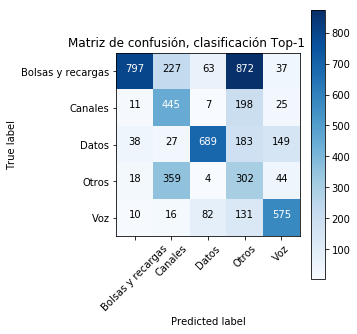

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Matriz de confusión, clasificación Top-1           ')

Normalized confusion matrix
[[0.4  0.11 0.03 0.44 0.02]
 [0.02 0.65 0.01 0.29 0.04]
 [0.03 0.02 0.63 0.17 0.14]
 [0.02 0.49 0.01 0.42 0.06]
 [0.01 0.02 0.1  0.16 0.71]]


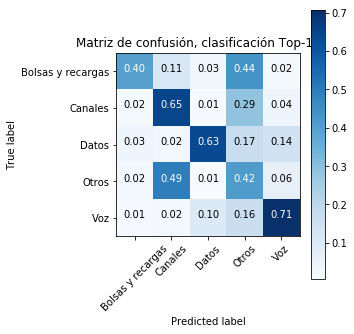

In [41]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Matriz de confusión, clasificación Top-1       ',normalize=True)

## Guardado final

In [42]:
from gensim.test.utils import datapath

#Guardado en formato Csv (final)
destino = os.path.join(root,"data","final")
if not os.path.exists(destino):
    os.makedirs(destino)

#Modelo/diccionario/dataframe/corpus    
lda.save(os.path.join(destino,"lda"))
dictionary.save_as_text(os.path.join(destino,"dictionary"))
test_df.to_excel(os.path.join(destino,"test_prepago_2019.xlsx"), encoding='utf-8', index=False)
MmCorpus.serialize(os.path.join(destino,'corpus_test.mm'), corpus_test)

# Aprendizaje supervisado

#### División dataframe test

Vía libreria KFold de sklearn se realiza generación de indices para llevar a cabo cross-validation sobre los conjuntos de muestras etiquetadas por el Edo.<br>

KFold recibe 2 numpy arrays, uno para el conjunto de features o inputs y uno para la variable objetivo o target.<br>

__Para continuar con trabajo creación otro algoritmo debe revisarse los valores posibles de MOTIVO, puesto que tienen una cardinalidad gigante y se requieren dummies.__

## Carga archivos

In [ ]:
origen_procesados = os.path.join(root,"data","final")
origen_etiquetas = os.path.join(root,"data","etiquetado")

# Import Bases
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
#    test_etiquetado_pp = pd.read_excel(os.path.join(origen_procesados,"test_prepago_2019.xlsx"), index_col = 0)
#    display("Dimensiones dataset original de test prepago:",test_etiquetado_pp.shape,test_etiquetado_pp.head())

    test_etiquetado = pd.read_excel(os.path.join(origen_etiquetas,"test_pp_2018_reducido.xlsx"), index_col=0)
    display("Dimensiones dataset original de test suscripcion:",test_etiquetado.shape,test_etiquetado.head())

    #Se carga un modelo previamente entrenado desde el disco. 
    lda = LdaModel.load(os.path.join(origen_procesados,"lda"))

    #Se cargan además el diccionario y el corpus con el que se entrenó a dicho modelo
    dictionary = Dictionary.load_from_text(os.path.join(origen_procesados,"dictionary.dict"))
    corpus = MmCorpus(os.path.join(origen_procesados,"corpus_test.mm"))

In [5]:
#Corrección de las etiquetas prepago
test_etiquetado['M1'] = test_etiquetado['M1'].str.lower()
test_etiquetado['M1'] = test_etiquetado['M1'].str.capitalize()
display(test_etiquetado["M1"].unique())

array(['Bolsas y recargas', 'Otros', 'Datos', 'Voz'], dtype=object)

<Figure size 3200x2400 with 0 Axes>

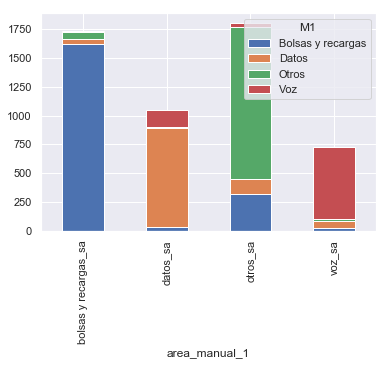

<Figure size 3200x2400 with 0 Axes>

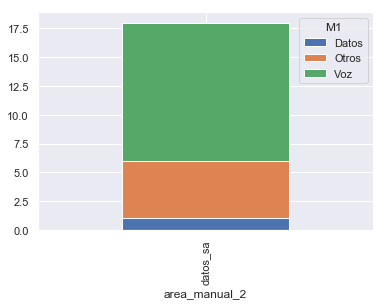

<Figure size 3200x2400 with 0 Axes>

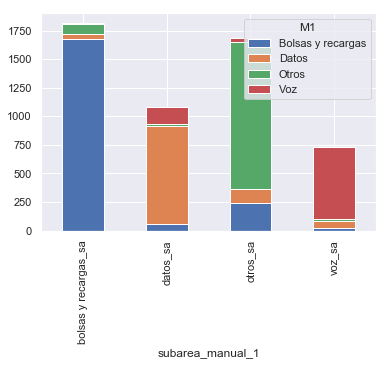

<Figure size 3200x2400 with 0 Axes>

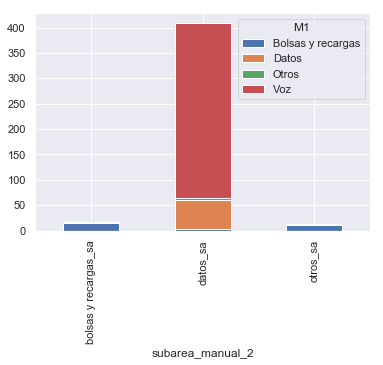

In [6]:
#Operacion
import seaborn as sns
from matplotlib.pyplot import figure
sns.set()

df_plot = test_etiquetado.groupby(['M1', 'area_manual_1']).size().reset_index().pivot(columns='M1', index='area_manual_1', values=0)
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
df_plot.plot(kind='bar', stacked=True)
df_plot = test_etiquetado.groupby(['M1', 'area_manual_2']).size().reset_index().pivot(columns='M1', index='area_manual_2', values=0)
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
df_plot.plot(kind='bar', stacked=True)


#Suboperacion
df_plot = test_etiquetado.groupby(['M1', 'subarea_manual_1']).size().reset_index().pivot(columns='M1', index='subarea_manual_1', values=0)
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
df_plot.plot(kind='bar', stacked=True)
df_plot = test_etiquetado.groupby(['M1', 'subarea_manual_2']).size().reset_index().pivot(columns='M1', index='subarea_manual_2', values=0)
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
df_plot.plot(kind='bar', stacked=True)

plt.show()

### 1. Outliers y datos de índole extraña

Estadistica descriptiva df y tipos

In [7]:
display(test_etiquetado.describe(),test_etiquetado.dtypes,test_etiquetado.keys())

,MES
count,5309.000000
mean,6.463929
std,3.444641
min,1.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,12.000000


Contacto            object
MES                  int64
Grupo cliente       object
Área                object
Subárea             object
Descripción         object
M1                  object
M2                  object
M3                  object
Pred_M1             object
Pred_M2             object
Pred_M3             object
area_manual_1       object
area_manual_2       object
subarea_manual_1    object
subarea_manual_2    object
dtype: object

Index(['Contacto', 'MES', 'Grupo cliente', 'Área', 'Subárea', 'Descripción',
       'M1', 'M2', 'M3', 'Pred_M1', 'Pred_M2', 'Pred_M3', 'area_manual_1',
       'area_manual_2', 'subarea_manual_1', 'subarea_manual_2'],
      dtype='object')

### 2. Preprocesamiento

Se pre procesan los datos para utilizar los algoritmos de clasificación. Se realizan las siguientes modificaciones:

In [8]:
#Preprocesamiento para MLP, 
#Grupo cliente  -> Dummies
#Operacion -> Dummies
#Suboperacion -> Dummies
#Motivo -> Dummies
mercado = "pp"
def pre_procesamiento_dummies(data,mercado):  
    BASE = data.copy(deep=True)
    
    if mercado == "ss":
        #Generación dummies
        keys = ["Operación manual 1","Operación manual 2","Suboperación manual 1",
                "Suboperación manual 2","Motivo manual 1","Motivo manual 2","Grupo_Cliente"]
        dfs = [pd.get_dummies(BASE[[k]]) for k in keys]
        BASE = BASE.join(dfs[0:], how = "outer")

        #Remoción columnas sobrantes
        r_keys = ["MES","Grupo_Cliente","M3","Requerimiento_Del_Cliente","Operacion","Operación manual 1","Operación manual 2",
                  "Suboperacion","Suboperación manual 1","Suboperación manual 2","Motivo","Motivo manual 1","Motivo manual 2"]
        BASE = BASE.drop(r_keys[0:], axis=1)
    
    if mercado == "pp":
        #Generación dummies
        keys = ["area_manual_1","area_manual_2","subarea_manual_1","subarea_manual_2","Grupo cliente"]
        dfs = [pd.get_dummies(BASE[[k]]) for k in keys]
        BASE = BASE.join(dfs[0:], how = "outer")
        
        #Remoción columnas sobrantes
        r_keys = ["MES","Grupo cliente","Área","area_manual_1","area_manual_2","Subárea","subarea_manual_1","subarea_manual_2"]
        BASE = BASE.drop(r_keys[0:], axis=1)
        
        if type(BASE.Descripción.iloc[0]) == str:
            txts = [txt.split() for txt in list(BASE["Descripción"])]
            BASE["Descripción"] = txts
    else:
        print("ERROR, se debe seleccionar mercado prepagos: 'pp' o suscritos: 'ss' para llevar a cabo preprocesamiento.")
        
    return BASE

In [15]:
#Preprocesamiento
data_preprocesada = pre_procesamiento_dummies(test_etiquetado,mercado)

In [16]:
from config_bt_prepago import*

import predicciones

In [ ]:
#Se añaden las predicciones
indices = data_preprocesada.index

pred_test = predicciones.prediccion_conjunto_test(lda,dictionary,data_preprocesada,pmin=0.35,modo=0,verbose=False)
pred_test= pred_test.set_index(indices)


test_df[["M1","M2","M3"]] = test_etiquetado[["M1","M2","M3"]].values

df_final = pd.concat([data_preprocesada, pred_test], axis=1)
display(df_final.head())
display(df_final.shape)

In [19]:
df_final.keys()

Index(['Contacto', 'Descripción', 'M1', 'M2', 'M3', 'Pred_M1', 'Pred_M2',
       'Pred_M3', 'area_manual_1_bolsas y recargas_sa',
       'area_manual_1_datos_sa', 'area_manual_1_otros_sa',
       'area_manual_1_voz_sa', 'area_manual_2_datos_sa',
       'subarea_manual_1_bolsas y recargas_sa', 'subarea_manual_1_datos_sa',
       'subarea_manual_1_otros_sa', 'subarea_manual_1_voz_sa',
       'subarea_manual_2_bolsas y recargas_sa', 'subarea_manual_2_datos_sa',
       'subarea_manual_2_otros_sa', 'Grupo cliente_Prepago', 'Pred_M1',
       'Pred_M2', 'Pred_M3'],
      dtype='object')

##### Actualización modelo 10/05/2019

"Evaluating learning parameters. Online LDA introduces several learning parameters: $κ$ ∈
(0.5, 1], which controls how quickly old information is forgotten; $\tau_0 ≥ 0$, which downweights early
iterations; and the mini-batch size S, which controls how many documents are used each iteration.
Although online LDA converges to a stationary point for any valid $κ$, $\tau_0$, and $S$, the quality of this
stationary point and the speed of convergence may depend on how the learning parameters are set..." ([OLDA](https://www.di.ens.fr/~fbach/mdhnips2010.pdf))<br>

OJO: según documentación, una vez un modelo se ha entrenado no se puede actualizar el vocabulario del mismo. En consecuencia, se debe actualizar el diccionario que crea el doc2bow, preprocesar nuevamente todas las muestras que entrenaron modelo original con dicho diccionario, reentrenar modelo original con ese diccionario, y, recién ahí, hacer el update.

In [ ]:
lda.update(corpus = corpus_nuevo, chunksize =20, decay=0.5, offset=64)

In [ ]:
from sklearn.model_selection import KFold
#Creacion arrays features y target
y = test_etiquetado["M1"].values
X = test_etiquetado[["Operacion","Suboperacion","Motivo"]].values

kf = KFold(n_splits=5, random_state = 5)
kf.get_n_splits(test_etiquetado.values)

print(kf)  

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]